Extending on my traffic safety / city commuting rates jupyter notebook (https://github.com/moralwintertiger/Traffic_Safety/blob/master/City_Commuting_Rates.ipynb) this notebook will build out an api to quickly assemble data on commuting by city. The notebook should act as a road map to building other apis with datausa. 

In [31]:
###example url, which graphs commute types (by vehicle, eg) in Los Angeles. This url appears to be in json format. 

url = "http://graphite.datausa.io/api/data?measure=Commute%20Means,Commute%20Means%20Moe&geo=16000US0644000,01000US&drilldowns=Group"

let's see if we can pull out the data from that url into a dataframe. First we'll import the required libraries, then 
we'll decompose the url. 



In [6]:
import requests, json
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
###note that to make an api request via the requests package, you need to input your user-agent info:


headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.132 Safari/537.36'}


In [45]:
#now let's get out test url:

json = requests.get(url, headers=headers).json()

json

{'data': [{'Commute Means': 238540,
   'Commute Means Moe': 9648,
   'Geography': 'United States',
   'Group': 'Motorcycle',
   'ID Geography': '01000US',
   'ID Group': 4,
   'ID Year': 2017,
   'Slug Geography': 'united-states',
   'Year': '2017'},
  {'Commute Means': 126091,
   'Commute Means Moe': 6902,
   'Geography': 'Los Angeles, CA',
   'Group': 'Worked At Home',
   'ID Geography': '16000US0644000',
   'ID Group': 8,
   'ID Year': 2017,
   'Slug Geography': 'los-angeles-ca',
   'Year': '2017'},
  {'Commute Means': 22682,
   'Commute Means Moe': 2792,
   'Geography': 'Los Angeles, CA',
   'Group': 'Other',
   'ID Geography': '16000US0644000',
   'ID Group': 7,
   'ID Year': 2017,
   'Slug Geography': 'los-angeles-ca',
   'Year': '2017'},
  {'Commute Means': 13604253,
   'Commute Means Moe': 77767.85546098079,
   'Geography': 'United States',
   'Group': 'Carpooled',
   'ID Geography': '01000US',
   'ID Group': 1,
   'ID Year': 2017,
   'Slug Geography': 'united-states',
   'Year

In [43]:
#to determine which data to pull out, let's look at an example entry. As you can see, there are several entries in 
###json['data'][1], meaning as we iterate through to build our df we'll want to use json['data'][i] with an additional
###index, for example json['data'][i]['Commue Means']

json['data'][1]

{'Commute Means': 126091,
 'Commute Means Moe': 6902,
 'Geography': 'Los Angeles, CA',
 'Group': 'Worked At Home',
 'ID Geography': '16000US0644000',
 'ID Group': 8,
 'ID Year': 2017,
 'Slug Geography': 'los-angeles-ca',
 'Year': '2017'}

In [48]:
###let's see if we can return the desired fields from this entry. We want 'commute means', 'Group', 'Year', and 'Geography'
###from this data we'll then calculate the proportion (here we only have the counts)

test_list = [json['data'][1]['Commute Means'], json['data'][1]['Group'], json['data'][1]['Year'], json['data'][1]['Geography']]
test_list

#seems to have worked out. Now let's use this same logic to build a full dataframe. 

[126091, 'Worked At Home', '2017', 'Los Angeles, CA']

In [103]:
la_df = pd.DataFrame()
la_df['Commute_Means'] = [json['data'][i]['Commute Means'] for i in range(len(json['data']))]
la_df['Group'] = [json['data'][i]['Group'] for i in range(len(json['data']))]
la_df['Year'] = [json['data'][i]['Year'] for i in range(len(json['data']))]
la_df['Geography'] = [json['data'][i]['Geography'] for i in range(len(json['data']))]

#lastly, let's remove the USA rows:

la_df = la_df[la_df['Geography'] != 'United States']

In [150]:
#now let's build all that info a function:

##note that for each city we will need a fips code (more on generating that below). Example here is LA City, fips code 0644000

def build_city_df(fips_code):
    
    '''takes a FIPS code as a string input and outputs a pandas dataframe of transpo data for that FIPS code'''
    
    output_df = pd.DataFrame()
    base_url = url = "http://graphite.datausa.io/api/data?measure=Commute%20Means,Commute%20Means%20Moe&geo=16000US"
    
    tail = ",01000US&drilldowns=Group"
    url = base_url+fips_code+tail
    json = requests.get(url, headers=headers).json()
    
    output_df['Commute_Means'] = [json['data'][i]['Commute Means'] for i in range(len(json['data']))]
    output_df['Group'] = [json['data'][i]['Group'] for i in range(len(json['data']))]
    output_df['Year'] = [json['data'][i]['Year'] for i in range(len(json['data']))]
    output_df['Geography'] = [json['data'][i]['Geography'] for i in range(len(json['data']))]
    
    output_df = output_df[output_df['Geography'] != 'United States']
    
    
    return output_df
    
    
    
    
    
    
    

,Commute_Means,Group,Year,Geography
1,126091,Worked At Home,2017,"Los Angeles, CA"
2,22682,Other,2017,"Los Angeles, CA"
4,65878,Walked,2017,"Los Angeles, CA"
6,18171,Bicycle,2017,"Los Angeles, CA"
8,4090,Motorcycle,2017,"Los Angeles, CA"


In [124]:
##now about building those fips codes. I've downloaded a file from the us census containing all geocodes:

fips_file = pd.read_excel("all-geocodes-v2016.xlsx")



'0644000'

In [137]:
##note that the above file came through with many values = 000000, which has the effect of splitting our data. Remove those:

fips_file = fips_file[fips_file['Unnamed: 4'] != "00000"]


In [234]:
fips_file[fips_file['Unnamed: 6'] == "Los Angeles city"]

,Estimates Geography File: Vintage 2016,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
1696,162,06,000,00000,44000,00000,Los Angeles city


In [138]:
#using the above file, we can make a fips locator. This would be most useful if we removed case sensitivity etc., 
#but for now just follow the format: Los Angeles city, Chicago city, etc. 

def retrieve_fips(city):
    entry = fips_file[fips_file['Unnamed: 6'] == city]
    code = str(entry['Unnamed: 1'].values[0]) + str(entry['Unnamed: 4'].values[0])
    return code

la_fips = retrieve_fips("Los Angeles city")
la_fips

'0644000'

In [140]:
#putting them together, we get an LA-specific df:

la_df = build_city_df(la_fips)
la_df.head()

,Commute_Means,Group,Year,Geography
1,126091,Worked At Home,2017,"Los Angeles, CA"
2,22682,Other,2017,"Los Angeles, CA"
4,65878,Walked,2017,"Los Angeles, CA"
6,18171,Bicycle,2017,"Los Angeles, CA"
8,4090,Motorcycle,2017,"Los Angeles, CA"


'1714000'

In [197]:
##let's combine the functionality of these two into one function:


def build_city_df_from_name(name):
    
    '''takes a city name as a string input, generatees a FIPS code, and outputs a 
    pandas dataframe of transpo data for that FIPS code'''
    
    entry = fips_file[fips_file['Unnamed: 6'] == name]
    fips_code = str(entry['Unnamed: 1'].values[0]) + str(entry['Unnamed: 4'].values[0])
    
    
    output_df = pd.DataFrame()
    base_url = url = "http://graphite.datausa.io/api/data?measure=Commute%20Means,Commute%20Means%20Moe&geo=16000US"
    
    tail = ",01000US&drilldowns=Group"
    url = base_url+fips_code+tail
    json = requests.get(url, headers=headers).json()
    
    output_df['Commute_Means'] = [json['data'][i]['Commute Means'] for i in range(len(json['data']))]
    output_df['Group'] = [json['data'][i]['Group'] for i in range(len(json['data']))]
    output_df['Year'] = [json['data'][i]['Year'] for i in range(len(json['data']))]
    output_df['Geography'] = [json['data'][i]['Geography'] for i in range(len(json['data']))]
    
    output_df = output_df[output_df['Geography'] != 'United States']
    
    
    return output_df

In [ ]:
def build_city_df_by_year(name, year):
    
    '''takes a city name and year as a string input, generatees a FIPS code, and outputs a 
    pandas dataframe of transpo data for that FIPS code and a specific year. This function also includes
    a column for the share of users engaging in a particular transport type'''
    
    entry = fips_file[fips_file['Unnamed: 6'] == name]
    fips_code = str(entry['Unnamed: 1'].values[0]) + str(entry['Unnamed: 4'].values[0])
    
    
    output_df = pd.DataFrame()
    base_url = url = "http://graphite.datausa.io/api/data?measure=Commute%20Means,Commute%20Means%20Moe&geo=16000US"
    
    tail = ",01000US&drilldowns=Group"
    url = base_url+fips_code+tail
    json = requests.get(url, headers=headers).json()
    
    output_df['Commute_Means'] = [json['data'][i]['Commute Means'] for i in range(len(json['data']))]
    output_df['Group'] = [json['data'][i]['Group'] for i in range(len(json['data']))]
    output_df['Year'] = [json['data'][i]['Year'] for i in range(len(json['data']))]
    output_df['Geography'] = [json['data'][i]['Geography'] for i in range(len(json['data']))]
    
    #remove usa total data:
    
    output_df = output_df[output_df['Geography'] != 'United States']
    
    ##restrict year:
    
    output_df = output_df[output_df['Year'] == str(year)]
    
    ##add a share column:
    
    total = output_df['Commute_Means'].sum()
    output_df['share'] = output_df['Commute_Means']/total
    
    return output_df

In [149]:
#looks like everything is working. 

la_df = build_city_df_from_name("Los Angeles city")
la_df.head()

,Commute_Means,Group,Year,Geography
1,126091,Worked At Home,2017,"Los Angeles, CA"
2,22682,Other,2017,"Los Angeles, CA"
4,65878,Walked,2017,"Los Angeles, CA"
6,18171,Bicycle,2017,"Los Angeles, CA"
8,4090,Motorcycle,2017,"Los Angeles, CA"


Now that we have a pipeline to generate datasets by city name, let's make a few datasets to compare:

In [238]:
la_df = build_city_df_by_year("Los Angeles city", 2017)
sf_df = build_city_df_by_year("San Francisco city", 2017)
chicago_df = build_city_df_by_year("Chicago city", 2017)
atlanta_df = build_city_df_by_year("Atlanta city", 2017)
san_diego_df = build_city_df_by_year("San Diego city", 2017)
nyc_df = build_city_df_by_year("New York city", 2017)



Now that we can easily create a bunch of dataframes with transit data, let's build some functions that allow quick comparison plots between these data. 

In [209]:
def compare_transit_mode(*argv):
    for arg in argv:
        print(arg)

In [251]:
def compare_transit_mode(means, *argv):
    
    '''compares the share of commuters using a given means of transport across an unspecified number of 
    city dataframes'''
    
    output_df = pd.DataFrame(columns=["city", "share"])
    for arg in argv:
        share = (arg[arg['Group'] == str(means)])['share'].values[0]
        city = arg['Geography'].values[0]
        output_df = output_df.append({"city": city, "share":share}, ignore_index=True).sort_values(by=['share'])
    return output_df

In [253]:
compare_transit_mode('Walked', nyc_df, sf_df, la_df, chicago_df, atlanta_df)

,city,share
0,"Los Angeles, CA",0.033066
4,"Atlanta, GA",0.046062
1,"Chicago, IL",0.066468
2,"New York, NY",0.101010
3,"San Francisco, CA",0.119511


In [283]:
#now finally get to plotting:

#from bokeh.io import output_file, show
from bokeh.layouts import column
from bokeh.plotting import figure, show, output_file

In [ ]:
def compare_transit_mode(means, *argv):
    
    '''compares the share of commuters using a given means of transport across an unspecified number of 
    city dataframes'''
    
    output_df = pd.DataFrame(columns=["city", "share"])
    for arg in argv:
        share = (arg[arg['Group'] == str(means)])['share'].values[0]
        city = arg['Geography'].values[0]
        output_df = output_df.append({"city": city, "share":share}, ignore_index=True).sort_values(by=['share'])
    
    
    
    return output_df

In [303]:
walked = compare_transit_mode('Walked', nyc_df, sf_df, la_df, chicago_df, atlanta_df)

In [391]:
#possible to color yellow if includes LA?

def plotby_transit_mode(means, *argv):
    
    '''plots the share of commuters using a given means of transport across an unspecified number of 
    city dataframes. If LA is included in the list of cities, it is plotted in gold.'''
    
    output_df = pd.DataFrame(columns=["city", "share"],index=None)
    for arg in argv:
        share = (arg[arg['Group'] == str(means)])['share'].values[0]
        city = arg['Geography'].values[0]
        output_df = output_df.append({"city": city, "share":share}, ignore_index=True).sort_values(by='share', ascending=False).reset_index(drop=True)
       
    cities = [output_df['city'][i] for i in range(len(output_df['city'].values))]
    share = [output_df['share'][i] for i in range(len(output_df['share'].values))]
    
    color_list = []
    for city in cities:
        if city=="Los Angeles, CA":
            color_list.append("gold")
        else:
            color_list.append("navy")
            
    
    
    p = figure(y_range=cities, plot_height=400, title= str(means) + ", proportion by city")
    p.hbar(y=cities, right=share, height=.9, color=color_list)
    show(p)
    #return cities, share

In [395]:
plotby_transit_mode('Walked', nyc_df, sf_df, la_df, chicago_df, atlanta_df)
plotby_transit_mode('Bicycle', nyc_df, sf_df, la_df, chicago_df, atlanta_df)
plotby_transit_mode('Public Transit', nyc_df, sf_df, la_df, chicago_df, atlanta_df)
plotby_transit_mode('Taxi', nyc_df, sf_df, la_df, chicago_df, atlanta_df)
plotby_transit_mode('Drove Alone', nyc_df, sf_df, la_df, chicago_df, atlanta_df)


In [396]:
plotby_transit_mode('Carpooled', nyc_df, sf_df, la_df, atlanta_df)

In [393]:
nyc_df.head(10)

,Commute_Means,Group,Year,Geography,share
1,173304,Worked At Home,2017,"New York, NY",0.042552
2,22946,Other,2017,"New York, NY",0.005634
4,411388,Walked,2017,"New York, NY",0.101010
6,51733,Bicycle,2017,"New York, NY",0.012702
8,3780,Motorcycle,2017,"New York, NY",0.000928
10,41653,Taxi,2017,"New York, NY",0.010227
12,2272028,Public Transit,2017,"New York, NY",0.557859
14,186153,Carpooled,2017,"New York, NY",0.045707
16,909776,Drove Alone,2017,"New York, NY",0.223381


In [447]:
###would be useful to stack the 'by transit type' data for each city, such that we have a multi-colored bar where
###each color is a transit type. First let's build a function that reorganizes the data how we want it:

def build_df_row(*argv):
    
    '''eats a set of city dataframes and spits out a df of the top transpo types'''
    
    output_df = pd.DataFrame()
    
    for city in argv:
        name = city.at[1,'Geography']
        walk = city.at[4,'share']
        drove_alone = city.at[16,'share']
        bicycle = city.at[6,'share']
        public_transit = city.at[12,'share']
        other = 1-(walk + drove_alone + bicycle + public_transit)
        row = {"City":name, "Walk":walk, "Drove Alone":drove_alone, "Bike":bicycle, "Public Transit":public_transit,
              "Other":other}
        output_df = output_df.append(row, ignore_index=True)
    return output_df.set_index('City')
        
    

In [451]:
stacked_df = build_df_row(la_df, sf_df, atlanta_df, nyc_df, chicago_df)


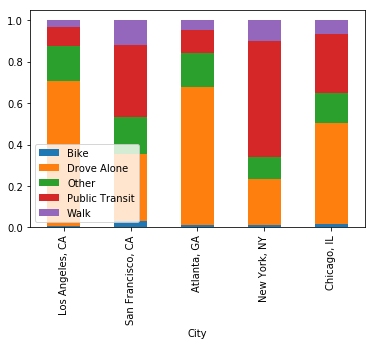

In [476]:
stacked_df.plot.bar(stacked=True)


In [557]:
#convert all sub-datasets to numpy arrays:
drove = np.array(stacked_df['Drove Alone'].tolist())
biked = np.array(stacked_df['Bike'].tolist())
walked = np.array(stacked_df['Walk'].tolist())
public_transit = np.array(stacked_df['Public Transit'].tolist())
other = np.array(stacked_df['Other'].tolist())




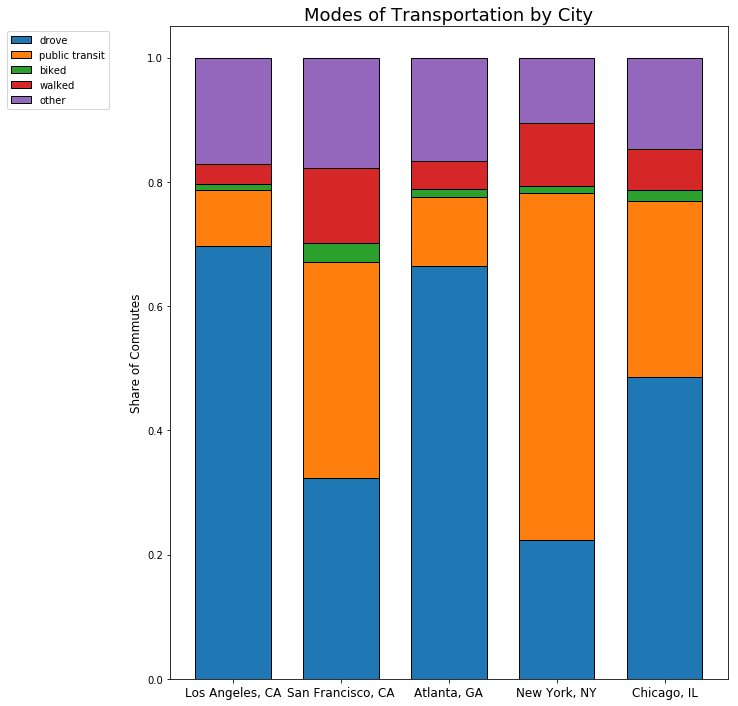

In [597]:
#kind of an ugly first pass. Let's pretty it up:

r = [0,1,2,3,4]
plt.figure(figsize=(10,12))

#overlay five bar types:


barWidth = .7
names = cities
transpo_type = stacked_df.columns.tolist()

p1 = plt.bar(r,drove, edgecolor="black", width=barWidth)
p2 = plt.bar(r, public_transit, edgecolor="black", bottom=drove, width=barWidth)
p3 = plt.bar(r, biked, edgecolor="black", bottom = drove + public_transit, width=barWidth)
p4 = plt.bar(r, walked, edgecolor="black", bottom=drove + public_transit + biked, width=barWidth)
p5 = plt.bar(r, other, edgecolor="black", bottom = drove + public_transit + biked + walked, width=barWidth)
plt.xticks(r, cities, fontsize=12)

plt.set_cmap('jet')
#plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), (header=['drove', 'public transit', 'biked', 'walked', 'other']) fontsize=12, ncol=1, bbox_to_anchor=(-.10,1), fancybox=True)
plt.title("Modes of Transportation by City", fontsize=18)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ['drove', 'public transit', 'biked', 'walked', 'other'], bbox_to_anchor=(-.1,1))
plt.ylabel("Share of Commutes", fontsize=12)

plt.show()
        
    


One more thing I'd like to see from the DATAUSA API for now is data on average commute time. Why do I want to see this? Because one of the main motivating arguments for not giving up cars/reducing car usage in LA is something along the lines of: it might be possible in some cities, but LA's car culture has build us into a city in which everything is too far apart to get there outside of driving. And nowhere is that case stronger than with commuting: when you picture Los Angeles, you picture someone stuck in their car on an interminable commute. What do the data say?

In [614]:

##let's repurpose some of the above code to retrieve data on commute times. We're only looking at average commute times
##here, which tells only part of the story unfortunately. 

commute_times_df = pd.DataFrame()

commute_times_url = "http://graphite.datausa.io/api/data?measure=Average Commute Time&drilldowns=Place"

##collect this info into a df:

commute_json = requests.get(commute_times_url, headers=headers).json()

commute_times_df['commute_time'] = [commute_json['data'][i]['Average Commute Time'] for i in range(len(commute_json['data']))]
commute_times_df['location'] = [commute_json['data'][i]['Place'] for i in range(len(commute_json['data']))]
commute_times_df['state'] = [commute_times_df['location'][i][-2:] for i in range(len(commute_times_df['location']))]

commute_times_df

,commute_time,location
0,18.226378,"Tallahassee, FL"
1,25.116210,"San Juan, PR"
2,23.110571,"Pittsburgh, PA"
3,21.561448,"Birmingham, AL"
4,18.457878,"Dothan, AL"
5,24.099817,"Reading, PA"
6,19.080299,"Huntsville, AL"
7,31.738563,"Philadelphia, PA"
8,18.030292,"Erie, PA"
9,21.008753,"Mobile, AL"


In [704]:
##build histogram for specific states:

import seaborn as sns

def hist_build_by_state(state):
    subset_df = commute_times_df[commute_times_df['state'] == str(state)]
    x_vals = subset_df['commute_time']
    if len(subset_df) > 100:    
        num_vals = len(subset_df)
        div = num_vals%5
        num_vals = num_vals-div
        bin_num = num_vals/5
        return sns.distplot(x_vals, kde=False, bins=int(bin_num))
    else:
        return sns.distplot(x_vals, kde=False, bins=15)

In [684]:
num_vals = len(ca)
div = num_vals%10
num_vals = num_vals-div
bin_num = num_vals/10
bin_num

39.0

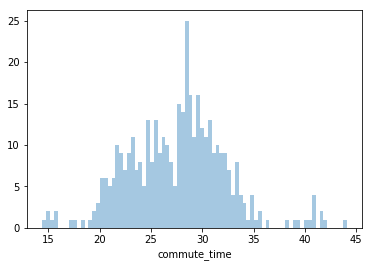

In [698]:
hist_build_by_state('CA')

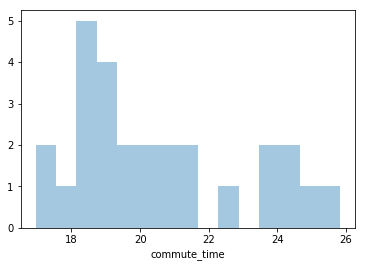

In [705]:
hist_build_by_state('GA')

In [696]:
ga = commute_times_df[commute_times_df['state'] == 'GA']
len(ga)

27

In [706]:
!pwd

/Users/ryan/Projects/Bikes/datausa/datausa
